In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import torch
from torch.autograd import Variable

from BNN import BNN
from BNNlayer import BNNLayer

# Regression Task with Bayesian Neural Network

## Data

We take a similar sinusoidal function as the one use in the article.
$$ y = 0.3\sin (2\pi(x+\epsilon)) + 0.3\sin (4\pi(x + \epsilon)) + \epsilon$$
$$\epsilon \sim \mathcal{N}(0,0.02^2) $$

In [3]:
def f(x, sigma=0):
    '''Generate data as in section 5.2 from paper'''
    noise = np.random.normal(0, np.sqrt(sigma), len(x))
    y = x + 0.3*np.sin(2*np.pi*(x + noise)) + 0.3*np.sin(4*np.pi*(x + noise)) 
    return y + noise

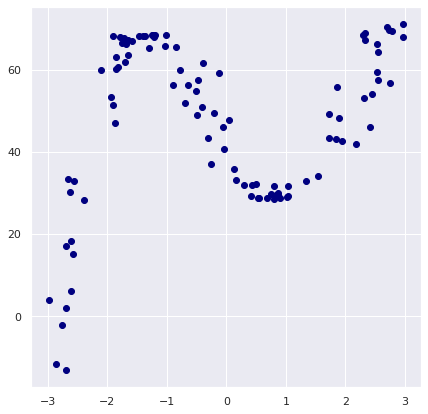

In [4]:
n = 100
sigma = 0.02**2

x = np.random.uniform(0, 6, n)
y = f(x/10, sigma=sigma).reshape(-1,1)*100
x = x-3
x = x.reshape((-1,1))

x_ = np.linspace(-6, 14)
y_ = f(x_/10, sigma=0)*100
x_ = x_ - 3

# Plotting
plt.figure(figsize=(7,7))
plt.scatter(x, y, c='navy', label='target')
#plt.axis("off")
plt.show()


# Bayesian Learning with Neural Network

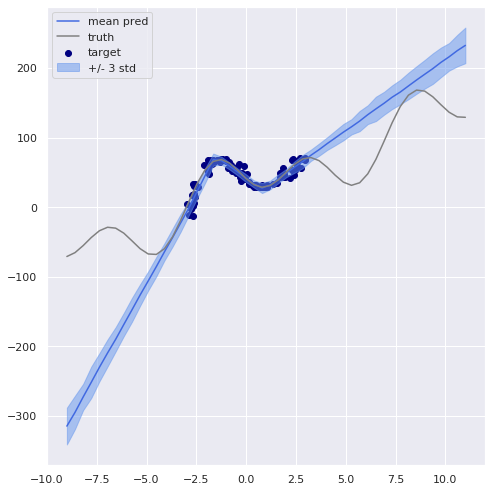

In [5]:
ep = 500

Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))
X = Var(x)
Y = Var(y)

# Initialize network
bnn = BNN(BNNLayer(1, 100, activation='relu', prior_mean=0, prior_rho=0),
          BNNLayer(100, 1, activation='none', prior_mean=0, prior_rho=0))

# Optimizer
optim = torch.optim.Adam(bnn.parameters(), lr=1e-1)

# Main training loop
for i_ep in range(ep):
    kl, lg_lklh = bnn.Forward(X, Y, 1)
    loss = BNN.loss_fn(kl, lg_lklh, 1)
    optim.zero_grad()
    loss.backward()
    optim.step()

# Plotting
plt.figure(figsize=(7,7))
plt.scatter(x, y, c='navy', label='target')

X_ = Var(x_).unsqueeze(1)

pred_lst = [bnn.forward(X_, mode='MC').data.numpy().squeeze(1) for _ in range(100)]

pred = np.array(pred_lst).T
pred_mean = pred.mean(axis=1)
pred_std = pred.std(axis=1)

plt.plot(x_, pred_mean, c='royalblue', label='mean pred')
plt.fill_between(x_, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                 color='cornflowerblue', alpha=.5, label='+/- 3 std')

plt.plot(x_, y_, c='grey', label='truth')

plt.legend()
plt.tight_layout()
#plt.axis("off")
plt.show()